#   <CENTER>PORTFOLIO 2</CENTER>
## Task P2.2
### Realize an implementation of the <b>Particle Filter</b> in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Particle Filter is to estimate the positions and velocity vectors of two balls flying simultaneously only from the observed erroneous positions over time.


### Importing Modules

In [324]:
#importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Constants

In [325]:
G = 9.81
dt = 0.1  # seconds
NUM_PARTICLES = 1000 #Number of particles
obs_noise_covar = np.diag([0.3, 0.3])**2


#### Ball Trajectory Simulation for Particle Filter

In [326]:
def ball_trajectory_simulation(launch_position, launch_speed, launch_angle, dt, duration, g=G):
    
    # Convert launch angle to radians
    launch_angle_rad = np.deg2rad(launch_angle)

    # Calculate initial velocity components
    initial_velocity_x = launch_speed * np.cos(launch_angle_rad)
    initial_velocity_y = launch_speed * np.sin(launch_angle_rad)

    # Calculate time array
    t = np.arange(0, duration, dt)

    # Calculate ball position at each time step
    x = launch_position[0] + initial_velocity_x * t
    y = launch_position[1] + initial_velocity_y * t - 0.5 * g * t**2

    vx = initial_velocity_x * np.ones_like(t)
    vy = initial_velocity_y - g * t

    return x, y, vx, vy





#### Ball Observations Simulation for Particle Filter

In [327]:
def ball_observations_simulation(true_x, true_y, obs_noise_covar, obs_dropout_prob):
    n = len(true_x)  # Number of time steps

    # Generate random noise for observations
    obs_noise = np.random.multivariate_normal([0, 0], obs_noise_covar, n)

    # Simulate observations with dropout
    observations = np.empty((n, 2), dtype=np.float64)
    for i in range(n):
        if np.random.rand() > obs_dropout_prob:
            observations[i] = [true_x[i] + obs_noise[i, 0], true_y[i] + obs_noise[i, 1]]
        else:
            observations[i] = [np.nan, np.nan]

    return observations

#filling the missing (NaN) values in the observations using linear interpolation.
def fill_observations(observations):
    df = pd.DataFrame(observations)
    df_filled = df.interpolate(method='linear', limit_direction='both')
    return df_filled.to_numpy()

#Adjusts observations by clipping y-values to ensure they are non-negative
def adjust_observations(observations):
    adjusted_observations = observations.copy()
    adjusted_observations[:, 1] = np.maximum(adjusted_observations[:, 1], 0)  # Clip y-values to be non-negative
    return adjusted_observations




#### Particle Filter Implementation

In [328]:
#particle filter initialization
def initialize_particles(observations, num_particles, launch_speed, launch_angle):
    initial_observation = observations[0]
    if np.isnan(initial_observation).any():
        initial_observation = [0, 0]

    particles = np.zeros((num_particles, 4))
    particles[:, :2] = np.random.normal(initial_observation, scale=0.5, size=(num_particles, 2))
    particles[:, 2] = launch_speed * np.cos(np.deg2rad(launch_angle)) + np.random.normal(0, 0.1, num_particles)
    particles[:, 3] = launch_speed * np.sin(np.deg2rad(launch_angle)) + np.random.normal(0, 0.1, num_particles)
    return particles


def resample_particles(particles, weights):
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)
    return particles[indices]

#particle filter implementation function
def particle_filter(observations, num_particles, time_step, total_time, launch_speed, launch_angle, g=G):
    total_steps = int(total_time / time_step)
    particles = np.zeros((total_steps, num_particles, 4))
    weights = np.ones(num_particles) / num_particles
    estimated_position = np.zeros((total_steps, 2))

    particles[0] = initialize_particles(observations, num_particles, launch_speed, launch_angle)

    for step in range(total_steps):
        if step > 0:
            particles[step, :, 0] = particles[step - 1, :, 0] + particles[step - 1, :, 2] * time_step
            particles[step, :, 1] = particles[step - 1, :, 1] + particles[step - 1, :, 3] * time_step - 0.5 * g * time_step ** 2
            particles[step, :, 2] = particles[step - 1, :, 2]
            particles[step, :, 3] = particles[step - 1, :, 3] - g * time_step

        current_observation = observations[step]

        if not np.isnan(current_observation).any():
            diff = particles[step, :, :2] - current_observation
            distances = np.sum((diff @ np.linalg.inv(obs_noise_covar)) * diff, axis=1)
            weights = np.exp(-0.5 * distances)

            weight_sum = np.sum(weights)
            if weight_sum == 0 or np.isnan(weight_sum):
                weights = np.ones(num_particles) / num_particles
            else:
                weights /= weight_sum

            particles[step] = resample_particles(particles[step], weights)

        estimated_position[step] = np.mean(particles[step, :, :2], axis=0)

    return estimated_position


### Ball Simulation Parameters1

In [329]:
# Set up simulation parameters
initial_position_1 = [10, 10]
launch_speed_1 = 40  # m/s
launch_angle_1 = 25  # degrees

initial_position_2 = [0, 0]
launch_speed_2 = 50  # m/s
launch_angle_2 = 15  # degrees

duration = 3  # seconds
obs_noise_covar = np.diag([0.3, 0.3])**2
observation_dropout_prob = 0.1  #dropout probability


# Simulate ball trajectory and observations for ball 1
true_x_1, true_y_1, vx_1, vy_1  = ball_trajectory_simulation(initial_position_1, launch_speed_1, launch_angle_1, dt, duration)
observations_1 = ball_observations_simulation(true_x_1, true_y_1, obs_noise_covar, observation_dropout_prob)
adjusted_observations_1 = adjust_observations(fill_observations(observations_1))

# Simulate ball trajectory and observations for ball 2
true_x_2, true_y_2, vx_2, vy_2  = ball_trajectory_simulation(initial_position_2, launch_speed_2, launch_angle_2, dt, duration)
observations_2 = ball_observations_simulation(true_x_2, true_y_2, obs_noise_covar, observation_dropout_prob)
adjusted_observations_2 = adjust_observations(fill_observations(observations_2))

### Running particle filter for both balls

In [330]:
# Run particle filter for ball 1 with adjusted observations
estimated_position_1 = particle_filter(np.array(adjusted_observations_1), NUM_PARTICLES, dt, duration, launch_speed_1, launch_angle_1)

# Run particle filter for ball 2 with adjusted observations
estimated_position_2 = particle_filter(np.array(adjusted_observations_2), NUM_PARTICLES, dt, duration, launch_speed_2, launch_angle_2)


#### Plotting results for both balls on a single graph(Parameters 1)

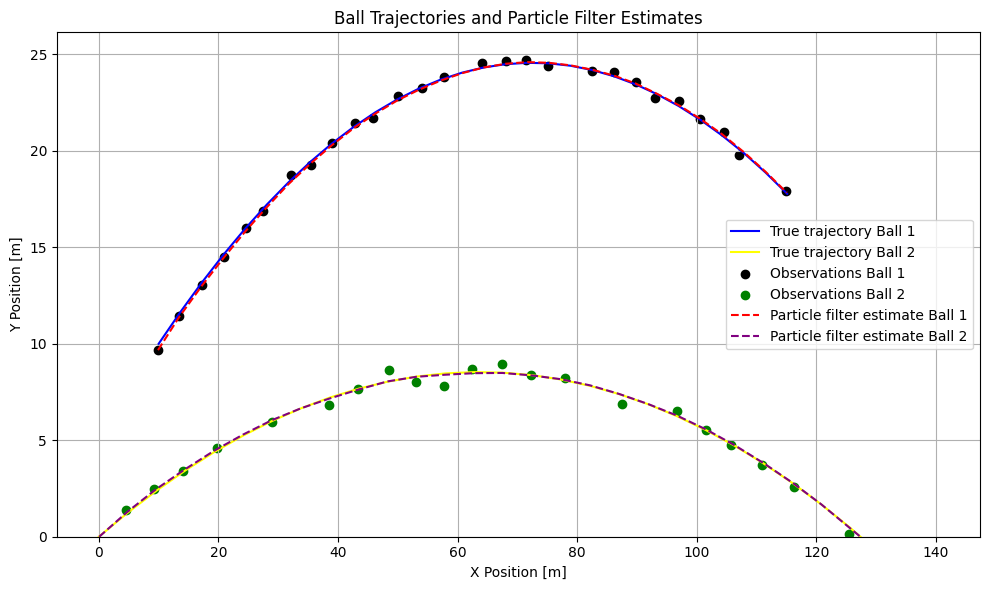

In [331]:
# Plot results for both balls on a single graph
plt.figure(figsize=(10, 6)) # Adjust figure size as needed

# Plot true trajectories for both balls
plt.plot(true_x_1, true_y_1, label="True trajectory Ball 1", color="blue")
plt.plot(true_x_2, true_y_2, label="True trajectory Ball 2", color="yellow")


# Scatter observations for both balls
plt.scatter(observations_1[:, 0], observations_1[:, 1], label="Observations Ball 1", color="black")
plt.scatter(observations_2[:, 0], observations_2[:, 1], label="Observations Ball 2", color="green")

# Plot particle filter estimates for both balls
plt.plot(estimated_position_1[:, 0], estimated_position_1[:, 1], label="Particle filter estimate Ball 1", color="red", linestyle="--")
plt.plot(estimated_position_2[:, 0], estimated_position_2[:, 1], label="Particle filter estimate Ball 2", color="purple", linestyle="--")

# Add labels, legend, and title
plt.legend()
plt.xlabel("X Position [m]")
plt.ylabel("Y Position [m]")
plt.title("Ball Trajectories and Particle Filter Estimates")
plt.grid(True)       # Add grid for better readability
plt.ylim(bottom=0)   # Ensure y-axis starts from 0
plt.tight_layout()   # Ensure tight layout
plt.show()


### Function to calculate error between estimated trajectory and real trajectory(Parameters 1)

In [332]:
def calculate_rmse(estimated_trajectory, true_trajectory):
    error = estimated_trajectory - true_trajectory
    rmse = np.sqrt(np.mean(error ** 2))
    return rmse


# Calculate RMSE for ball 1
rmse_1 = calculate_rmse(estimated_position_1, np.column_stack((true_x_1, true_y_1)))
print(f'RMSE for Ball 1: {rmse_1}')

# Calculate RMSE for ball 2
rmse_2 = calculate_rmse(estimated_position_2, np.column_stack((true_x_2, true_y_2)))
print(f'RMSE for Ball 2: {rmse_2}')

RMSE for Ball 1: 0.09118056702539037
RMSE for Ball 2: 0.08176489677876252


#   <CENTER>THANK YOU</CENTER>